In [1]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf

In [2]:
class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'serene-bliss-424807-s5'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'derma-foundation-model-images'  # @param

  # @markdown PAD Dataset files:
  # Metadata CSV from PAD dataset to read
  gcs_metadata_csv = 'ham_dataset/FilteredDiseases.csv'  # @param

  # Images directory:
  gcs_images_dir = 'derma-foundation-model-images/ham_dataset/images/'  # @param

  # Column name to use for the small model
  label_column = 'Disease'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'image' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = False  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'ham_dataset/embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 42
  embeddings_size = 8048
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.2 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df = None

  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model = None

In [3]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [4]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()


def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()

Token will expire at 2024-06-10 07:19:48 UTC (27.0 minutes)


In [5]:
from google.cloud import storage


def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  i=0
  # for blob in blobs:
  #   i+=1
  # print('total blobs = ',i)


def load_dataset(bucket, csv_path, images_dir):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()))
  df['img_path'] = df[Globals.img_join_column].apply(lambda x: os.path.join(images_dir, x))
  return df


Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
list_blobs(Globals.gcs_storage_client, Globals.gcs_bucket_name)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(Globals.gcs_bucket_name)
Globals.metadata_df = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir
)
Globals.all_col_vals = sorted(set(Globals.metadata_df[Globals.label_column]))
Globals.metadata_df

,Index,image,Disease,img_id,img_path
0,13,ISIC_0024318.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
1,24,ISIC_0024329.jpg,AKIEC,NaN,derma-foundation-model-images/ham_dataset/imag...
2,25,ISIC_0024330.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
3,65,ISIC_0024370.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...
4,67,ISIC_0024372.jpg,AKIEC,NaN,derma-foundation-model-images/ham_dataset/imag...
...,...,...,...,...,...
579,9686,ISIC_0033991.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...
580,9830,ISIC_0034135.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
581,9864,ISIC_0034169.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
582,9891,ISIC_0034196.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...


In [6]:
# @title Print interesting metadata
def print_metadata_stats(metadata_df: pd.DataFrame) -> None:
  print(f'Num Patients: {len(metadata_df)}')
  print('Column Names:')
  for column in metadata_df.columns:
    print(f'  {column}')
  print(
      f'Column values for "{Globals.label_column}":'
      f' {sorted(set(metadata_df[Globals.label_column]))}'
  )

In [7]:

print_metadata_stats(Globals.metadata_df)
Globals.metadata_df

Num Patients: 584
Column Names:
  Index
  image
  Disease
  img_id
  img_path
Column values for "Disease": ['AKIEC', 'DF', 'VASC']


,Index,image,Disease,img_id,img_path
0,13,ISIC_0024318.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
1,24,ISIC_0024329.jpg,AKIEC,NaN,derma-foundation-model-images/ham_dataset/imag...
2,25,ISIC_0024330.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
3,65,ISIC_0024370.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...
4,67,ISIC_0024372.jpg,AKIEC,NaN,derma-foundation-model-images/ham_dataset/imag...
...,...,...,...,...,...
579,9686,ISIC_0033991.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...
580,9830,ISIC_0034135.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
581,9864,ISIC_0034169.jpg,DF,NaN,derma-foundation-model-images/ham_dataset/imag...
582,9891,ISIC_0034196.jpg,VASC,NaN,derma-foundation-model-images/ham_dataset/imag...


In [8]:

# Count the number of rows for each disease type
disease_counts = Globals.metadata_df['Disease'].value_counts()

# Print the counts
print(disease_counts)


Disease
AKIEC    327
VASC     142
DF       115
Name: count, dtype: int64


In [9]:
Globals.metadata_df['img_path'] = Globals.metadata_df['img_path'].str.replace('derma-foundation-model-images/','', regex = False)
Globals.metadata_df.head()

,Index,image,Disease,img_id,img_path
0,13,ISIC_0024318.jpg,DF,NaN,ham_dataset/images/ISIC_0024318.jpg
1,24,ISIC_0024329.jpg,AKIEC,NaN,ham_dataset/images/ISIC_0024329.jpg
2,25,ISIC_0024330.jpg,DF,NaN,ham_dataset/images/ISIC_0024330.jpg
3,65,ISIC_0024370.jpg,VASC,NaN,ham_dataset/images/ISIC_0024370.jpg
4,67,ISIC_0024372.jpg,AKIEC,NaN,ham_dataset/images/ISIC_0024372.jpg


There are a total of 584 images. We will sample 3 to display.
Image 553


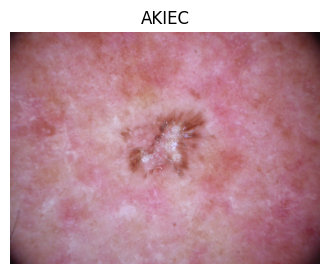

Image 191


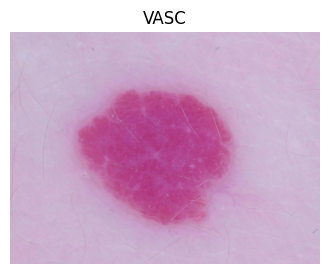

Image 136


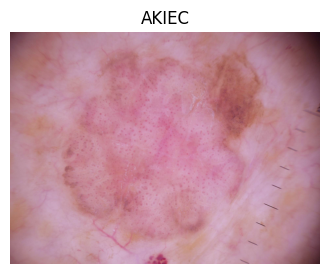

In [10]:
# @title Display image sample
import io
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def display_image(bucket, image_path, title):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size = 4
  f, axarr = plt.subplots(1, 1, figsize=(figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  axarr.set_title(title)
  plt.show()


def display_images(df, bucket, file_to_visualize=3):
  max_index = len(df['img_path'].values)
  print(
      f'There are a total of {max_index} images. '
      f'We will sample {file_to_visualize} to display.'
  )
  list_of_images = random.sample(range(0, max_index - 1), file_to_visualize)
  for image_idx in list_of_images:
    filename = df['img_path'].values[image_idx]
    diagnostic = df['Disease'].values[image_idx]
    print('Image %d' % image_idx)
    display_image(bucket, filename, title=diagnostic)


display_images(Globals.metadata_df, Globals.gcs_bucket)

In [11]:
# @title Helper: Save/load embeddings via numpy.savez


def convert_to_numpy_dict(embeddings):
  updated_embeddings = {}
  for filepath, embedding in embeddings.items():
    updated_embeddings[filepath] = np.array(embedding)
  return updated_embeddings


def save_embeddings_to_file(
    project_name, bucket_name, object_name, embeddings=None
):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name)
  data_dict = embeddings or convert_to_numpy_dict(Globals.embeddings)
  type(data_dict)
  try:
    with blob.open('wb', ignore_flush=True) as f:
      np.savez(f, **data_dict)
  except Exception as e:
    print(f'Saving embeddings failed: {e}')
    raise


def load_embeddings_from_file(project_name, bucket_name, object_name):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name)
  embeddings = dict()
  with blob.open('rb') as f:
    x = np.load(f)
    for k, v in x.items():
      embeddings[k] = v
  return embeddings

In [12]:
#@title Load embeddings
%%time
if Globals.gcs_use_precomputed_embeddings:
  err_msg = ('A path to precomputed_embeddings must be set when '
             '`gcs_use_precomputed_embeddings` is set. Found '
            f'{Globals.gcs_precomputed_embeddings}')
  assert Globals.gcs_precomputed_embeddings, err_msg
  Globals.embeddings = load_embeddings_from_file(
      Globals.gcp_project,
      Globals.gcs_bucket_name,
      Globals.gcs_precomputed_embeddings)
print(f'Loaded {len(Globals.embeddings)} embeddings.')

Loaded 0 embeddings.
CPU times: user 1.14 ms, sys: 27 µs, total: 1.17 ms
Wall time: 6.64 ms


In [13]:
# @title Helpers: call Vertex predict
from typing import List
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf import struct_pb2

PredictionServiceClient = aiplatform.gapic.PredictionServiceClient


def create_prediction_service_client_and_endpoint_path():
  client_options = {
      'api_endpoint': (
          f'{Globals.vertex_endpoint_location}-aiplatform.googleapis.com'
      )
  }
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple
  # requests.
  client = PredictionServiceClient(client_options=client_options)
  endpoint_path = client.endpoint_path(
      project=Globals.vertex_endpoint_project_id,
      location=Globals.vertex_endpoint_location,
      endpoint=Globals.vertex_endpoint_id,
  )
  return client, endpoint_path


def get_prediction_instances(image_uris: List[str]):
  """Returns a list of JSON dicts to pass as Vertex PredictionService instances."""
  instances = []
  for image_uri in image_uris:
    instance_dict = {
        'bucket_name': Globals.gcs_bucket_name,
        'object_uri': image_uri,
        'bearer_token': Globals.gcs_creds.token,
    }
    instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
    instances.append(instance)
  return instances


def predict(
    client: PredictionServiceClient, endpoint_path: str, image_uris: List[str]
):
  """Calls predict for a Vertex endpoint using the given image paths."""
  instances = get_prediction_instances(image_uris)
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

In [14]:
%%time
#@title Example predict request
def run_single_predict_request(bucket_name, object_uri):
  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  assert Globals.gcs_creds.token, 'GCS Credential token is not valid. Re-run "Authenticate" section?'
  instance_dict = {
      'bucket_name': bucket_name,
      'object_uri': object_uri,
      'bearer_token': Globals.gcs_creds.token,
  }
  instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
  instances = [instance]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

# Example of how to run:
TEST_PREDICT_VAL = run_single_predict_request(
    bucket_name=Globals.gcs_bucket_name,
    object_uri='ham_dataset/images/ISIC_0024318.jpg')

# Note: The embedding is in TEST_PREDICT_VAL.predictions
print(TEST_PREDICT_VAL.deployed_model_id)
print(TEST_PREDICT_VAL.model)
print(TEST_PREDICT_VAL.model_display_name)
print(TEST_PREDICT_VAL.model_version_id)

8807129919927615488
projects/132886652110/locations/us-central1/models/dermatology
dermatology
5
CPU times: user 81.6 ms, sys: 18.5 ms, total: 100 ms
Wall time: 7.42 s


In [15]:
len(TEST_PREDICT_VAL.predictions[0])

6144

In [16]:
if Globals.gcs_use_precomputed_embeddings:
  # Check that the embeddings match.
  precomputed = Globals.embeddings['pad_dataset/images/PAT_1516_1765_530.png']
  assert len(precomputed) == len(TEST_PREDICT_VAL.predictions[0]), (
      f'Expected equal lengths: {len(precomputed)} !='
      f' {len(TEST_PREDICT_VAL.predictions[0])}'
  )
  print(f'First 10 items of the `precomputed` list:')
  print(precomputed[:10])
  print(f'First 10 items of the embedding from the above API call:')
  print(list(TEST_PREDICT_VAL.predictions[0])[:10])
  print('Asserting that the lists are equal:')
  assert list(precomputed) == TEST_PREDICT_VAL.predictions[0]

In [17]:
BATCH_COUNTER = collections.Counter()

In [18]:
#@title Generate embeddings concurrently
%%time
import concurrent.futures
import time

def refresh_credentials():
  # Refreshing is required b/c this can take longer than the typical 1-hr
  # timeout.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)

def run_predict(client, endpoint_path, img_paths, batch_id=None):
  # Ensure the GCS token has not yet expired. Otherwise `predict`
  # returns `500 Internal Error`.
  if not Globals.gcs_creds.valid:
    refresh_credentials()
    if not Globals.gcs_creds.valid:
      print('GCP Credentials are not valid.')
      return (None, None)
  start = time.time()
  try:
    predictions = predict(client, endpoint_path, img_paths)
  except Exception as e:
    print(f'Error generating embedding for {img_paths}: {e}')
    return (None, None)

  end = time.time()
  return (zip(img_paths, predictions.predictions), end-start, batch_id)


def generate_embeddings_concurrently(df, batch_size=1, num_workers=5):
  """Calls the API to compute embeddings for all images with no embedding yet."""
  # Generate batches of image paths to run the `predict` function with
  all_path_args = []
  for batch_start in np.arange(0, len(df), batch_size):
    batch_df = df.iloc[batch_start:batch_start+batch_size]
    img_paths = list(batch_df['img_path'])
    skip_iteration = True
    for img_path in img_paths:
      if img_path not in Globals.embeddings:
        skip_iteration = False
        break
    if skip_iteration:
      print(f'(skipped) {batch_start}')
      continue
    all_path_args.append(img_paths)

  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  total_embeddings = 0

  # Concurrently run `predict` requests for all image paths.
  overall_start = time.time()
  batch_counter = collections.Counter()
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(run_predict, client, endpoint_path, arg, batch_id=i) for i, arg in enumerate(all_path_args)]
    for future in concurrent.futures.as_completed(futures):
      preds, batch_time, batch_id = future.result()
      if preds is not None:
        print(f'{batch_id}: {batch_time}')
        batch_counter[int(batch_time)] += 1
        BATCH_COUNTER[int(batch_time)] += 1
        for img_path, pred in preds:
          Globals.embeddings[img_path] = pred
          total_embeddings += 1
  overall_end = time.time()
  print(f'Total embeddings retrieved: {total_embeddings}')
  print(f'Total time: {overall_end-overall_start}s ({overall_end-overall_start/60.0:.1f})')
  return batch_counter

REQUEST_TIMES = None
if Globals.gcs_use_precomputed_embeddings:
  print(f'WARNING: Skipping calculating embeddings. Precomputed embeddings will be used instead.')
if not Globals.gcs_use_precomputed_embeddings:
  # Note: You can scale up the number of workers after ~10m of making a high
  # volume of API calls.
  REQUEST_TIMES = generate_embeddings_concurrently(Globals.metadata_df)

4: 7.075478792190552
2: 7.5122692584991455
1: 10.993762493133545
0: 11.031632661819458
3: 11.1142897605896
5: 6.2715747356414795
6: 7.866507291793823
10: 7.989307403564453
9: 11.369806289672852
7: 11.562727212905884
8: 11.532670736312866
11: 7.7000861167907715
12: 7.945551633834839
13: 7.184674024581909
16: 7.780498027801514
15: 8.67996096611023
14: 8.811214208602905
20: 5.591548442840576
18: 7.573207378387451
17: 8.954115390777588
19: 7.6064794063568115
21: 8.22477388381958
22: 7.433900356292725
25: 7.027158498764038
23: 8.660783052444458
24: 8.690641641616821
26: 7.6755945682525635
27: 5.738886117935181
29: 6.902113914489746
31: 6.904489278793335
28: 8.900577068328857
30: 8.246571063995361
32: 7.140820264816284
35: 6.7469565868377686
33: 9.560221910476685
37: 6.798160552978516
34: 11.029531478881836
36: 10.223458290100098
38: 7.949791669845581
39: 7.831612586975098
40: 9.031834602355957
42: 7.7955427169799805
41: 8.857131242752075
43: 6.184255838394165
44: 7.508268356323242
45: 8.150

ValueError: not enough values to unpack (expected 3, got 2)

In [19]:
print(len(Globals.embeddings))
# len(TEST_PREDICT_VAL.predictions[0])
print(type(Globals.embeddings))

print(Globals.embeddings_size)

567
<class 'dict'>
8048


In [20]:
if len(Globals.embeddings) < len(Globals.metadata_df):
  raise ValueError(
      f'Expected {len(Globals.metadata_df)} embeddings to be present. '
      f'Got {len(Globals.embeddings)}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

ValueError: Expected 584 embeddings to be present. Got 567.
Maybe the "Generate embeddings" cell should be run again? This can happen if there are intermittent API errors.

In [ ]:
# @title Split data into train and validate

from sklearn import model_selection


def make_split(df, train_size=0.3):
  """Splits the dataframe into meaningful train/test sets.

  Note: This function attempts to have the condition distributions between train
  and test sets match (important because of significant class imbalance) and
  to have no overlapping patients (important to avoid data leakage).
  """
  gss = model_selection.GroupShuffleSplit(
      n_splits=1, train_size=train_size, random_state=Globals.random_state
  )
  train = None
  val = None
  for i, (train_index, test_index) in enumerate(
      gss.split(df, df[Globals.label_column], groups=df['Index'])
  ):
    train = df.iloc[train_index]
    val = df.iloc[test_index]
  print(
      f'Generated train split of length {len(train)} and validation split of'
      f' length {len(val)}'
  )
  return train, val


# Select a smaller portion of the data for training for demo purposes
Globals.df_train, Globals.df_validate = make_split(
    Globals.metadata_df, train_size=0.8
)

In [ ]:
def print_column_distribution_info(df, label_column):
  c = collections.Counter(df[label_column])
  total = sum(c.values())
  warnings = []
  for i in sorted(c.keys()):
    v = c[i]
    print(f'  {i} {v}/{total} ({100.0*v/total:.0f}%)')
    if v < 20:
      warnings.append(
          f'Less than 20 examples found for {i} ({v} examples). '
          'It will be difficult to learn from or evaluate so few examples!'
      )
  print('\n'.join(warnings))


print('df_train:')
print_column_distribution_info(
    Globals.df_train, label_column=Globals.label_column
)
print('df_validate:')
print_column_distribution_info(
    Globals.df_validate, label_column=Globals.label_column
)

In [ ]:
# @title Verify train and test sets have no overlapping patients
def verify_no_patient_intersection(df_train, df_validate):
  train_pids = set(df_train['Index'])
  validate_pids = set(df_validate['Index'])
  intersection = train_pids.intersection(validate_pids)
  assert (
      len(intersection) == 0
  ), f'Train and validate intersect ({len(intersection)}): {intersection}'


verify_no_patient_intersection(Globals.df_train, Globals.df_validate)
Globals.df_train

In [ ]:
# @title Library: display_str_histogram


def display_single_hist(ax, df, key, title=None):
  series = df[key]
  d = series.value_counts().to_dict()
  ax.bar(list(d.keys()), list(d.values()))
  ax.set_xlabel('Category')
  ax.set_ylabel('Count')
  title = title or f'Histogram of {key}'
  ax.set_title(title)


def display_str_histogram(dfs, key, titles=[]):
  assert len(dfs) < 5, "More than 5 dataframes won't look good"
  if len(dfs) == 1:
    fig, ax = plt.subplots()
    display_single_hist(ax, dfs[0], key, titles[0] if titles else '')
    return
  fig, axes = plt.subplots(1, len(dfs))
  for df, ax, title in zip(dfs, axes, titles):
    series = df[key]
    d = series.value_counts().to_dict()
    ax.bar(list(d.keys()), list(d.values()))
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    title = title or f'Histogram of {key}'
    ax.set_title(title)
  plt.tight_layout()
  plt.show()


# @title Histogram of 'diagnostic' column values
display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    Globals.label_column,
    titles=['train set', 'test set'],
)

In [ ]:
# @title sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression


def make_dataset(
    df,
    embeddings_map,
    label_key,
    all_categories=Globals.all_col_vals,
    num_samples=None,
):
  """Returns a tuple of (embeddings, int_class_labels) for the given df."""
  embeddings = []
  i = 0
  for _, row in df.iterrows():
    k = row["img_path"]
    embeddings.append(embeddings_map[k])
    if num_samples and i > num_samples:
      break
    i += 1
  int_labels = [
      all_categories.index(x) for x in df[label_key][: len(embeddings)]
  ]
  return embeddings, int_labels


def train_model(df_train, embeddings, label_column=Globals.label_column):
  """Returns a sklearn LogisticRegression model fit to the df_train."""
  train_x, train_y = make_dataset(df_train, embeddings, label_column)
  # https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  model = LogisticRegression(
      penalty="l2",
      solver="saga",
      multi_class="multinomial",
      max_iter=200,
      random_state=Globals.random_state,
  )
  model = model.fit(train_x, train_y)
  return model

In [ ]:
# @title Library: display_str_histogram


def display_single_hist(ax, df, key, title=None):
  series = df[key]
  d = series.value_counts().to_dict()
  ax.bar(list(d.keys()), list(d.values()))
  ax.set_xlabel('Category')
  ax.set_ylabel('Count')
  title = title or f'Histogram of {key}'
  ax.set_title(title)


def display_str_histogram(dfs, key, titles=[]):
  assert len(dfs) < 5, "More than 5 dataframes won't look good"
  if len(dfs) == 1:
    fig, ax = plt.subplots()
    display_single_hist(ax, dfs[0], key, titles[0] if titles else '')
    return
  fig, axes = plt.subplots(1, len(dfs))
  for df, ax, title in zip(dfs, axes, titles):
    series = df[key]
    d = series.value_counts().to_dict()
    ax.bar(list(d.keys()), list(d.values()))
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    title = title or f'Histogram of {key}'
    ax.set_title(title)
  plt.tight_layout()
  plt.show()




In [ ]:
# @title Histogram of 'diagnostic' column values
display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    Globals.label_column,
    titles=['train set', 'test set'],
)

In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def make_dataset_xgb(df, embeddings_map, label_key, all_categories=Globals.all_col_vals):
  """Returns a tuple of (embeddings, int_class_labels) for the given df."""
  embeddings = []
  for _, row in df.iterrows():
    k = row["img_path"]

    embeddings.append(embeddings_map[k])
  int_labels = [all_categories.index(x) for x in df[label_key][: len(embeddings)]]
  return embeddings, int_labels

def get_xgb_predictions(model, df, embeddings):
  """Generate predictions using the XGBoost model."""
  eval_x, eval_y = make_dataset_xgb(df, embeddings, Globals.label_column)
  dtest = xgb.DMatrix(data=eval_x, label=eval_y)
  y_pred_probs = model.predict(dtest)
  y_pred = np.argmax(y_pred_probs, axis=1)
  return y_pred, eval_y

# Get predictions on the validation set
y_pred, y_true = get_xgb_predictions(Globals.xgb_model, Globals.df_validate, Globals.embeddings)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=Globals.all_col_vals))

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print the accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def make_dataset_nn(df, embeddings_map, label_key, all_categories=Globals.all_col_vals):
    """Returns a tuple of (embeddings, one_hot_labels) for the given df."""
    embeddings = []
    for _, row in df.iterrows():
        k = row["img_path"]
        embeddings.append(embeddings_map[k])
    lb = LabelBinarizer()
    one_hot_labels = lb.fit_transform(df[label_key][: len(embeddings)])
    return np.array(embeddings), one_hot_labels

# Prepare training and validation datasets
train_x, train_y = make_dataset_nn(Globals.df_train, Globals.embeddings, Globals.label_column)
validate_x, validate_y = make_dataset_nn(Globals.df_validate, Globals.embeddings, Globals.label_column)

# Define the neural network model
def create_nn_model(input_dim, output_dim):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),

        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_dim = train_x.shape[1]
output_dim = train_y.shape[1]

nn_model = create_nn_model(input_dim, output_dim)

# Train the model
nn_model.fit(train_x, train_y, epochs=100, batch_size=128, validation_data=(validate_x, validate_y))

# Evaluate the model
validate_y_pred_probs = nn_model.predict(validate_x)
validate_y_pred = np.argmax(validate_y_pred_probs, axis=1)
validate_y_true = np.argmax(validate_y, axis=1)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(validate_y_true, validate_y_pred, target_names=Globals.all_col_vals))

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(validate_y_true, validate_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print the accuracy score
accuracy = accuracy_score(validate_y_true, validate_y_pred)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Function to create the neural network model
def create_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Prepare datasets
def make_dataset_nn(df, embeddings_map, label_key, all_categories):
    """Returns a tuple of (embeddings, one_hot_labels) for the given df."""
    embeddings = []
    for _, row in df.iterrows():
        k = row["img_path"]
        embeddings.append(embeddings_map[k])
    lb = LabelBinarizer()
    one_hot_labels = lb.fit_transform(df[label_key][: len(embeddings)])
    return np.array(embeddings), one_hot_labels

train_x, train_y = make_dataset_nn(Globals.df_train, Globals.embeddings, Globals.label_column, Globals.all_col_vals)
validate_x, validate_y = make_dataset_nn(Globals.df_validate, Globals.embeddings, Globals.label_column, Globals.all_col_vals)

# Model configuration
input_dim = train_x.shape[1]
output_dim = train_y.shape[1]

# Create and compile the model
model = create_model(input_dim, output_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128,
                    validation_data=(validate_x, validate_y),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
validate_y_pred_probs = model.predict(validate_x)
validate_y_true = np.argmax(validate_y, axis=1)

# Determine optimal thresholds from Precision-Recall curve
precision = dict()
recall = dict()
thresholds = dict()
optimal_thresholds = dict()
for i in range(output_dim):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(validate_y[:, i], validate_y_pred_probs[:, i])
    fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    optimal_idx = np.argmax(fscore)
    optimal_thresholds[i] = thresholds[i][optimal_idx]
    print(f"Optimal threshold for class {Globals.all_col_vals[i]}: {optimal_thresholds[i]}")

# Predict using optimal thresholds
validate_y_pred = np.zeros(validate_y.shape)
for i in range(output_dim):
    validate_y_pred[:, i] = (validate_y_pred_probs[:, i] >= optimal_thresholds[i]).astype(int)

validate_y_pred = np.argmax(validate_y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(validate_y_true, validate_y_pred, target_names=Globals.all_col_vals))

# Confusion matrix
conf_matrix = confusion_matrix(validate_y_true, validate_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy score
accuracy = accuracy_score(validate_y_true, validate_y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()

# Precision-Recall curve
plt.figure(figsize=(12, 8))
for i in range(output_dim):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {Globals.all_col_vals[i]} (area = {auc(recall[i], precision[i]):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')
plt.show()
